In [41]:
import argparse
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow_probability as tfp
from utils.coco_dataset_manager import *
from utils.yolo_utils import *
from utils.custom_retinanet import prepare_image
from utils.nonmaxsuppression import *
from utils.negloglikely import nll
from utils.yolov8prob import ProbYolov8Detector
from PIL import Image
import matplotlib.pyplot as plt
import math
#import torch

tf.keras.backend.clear_session()
tf.compat.v1.enable_eager_execution()
#torch.cuda.empty_cache()

# Hardcode paths and parameters
checkpoint_path = r"/remote_home/Thesis/Completed_Models/10xsquare"
image_folder = r"/remote_home/Thesis/DataFiles/small_test_videos/BDD_val_b1c9c847-3bda4659"
cls_path = r"/remote_home/Thesis/Prebayesian/class_list_traffic.txt"
download_path = r"/remote_home/Thesis/Prebayesian/download_list_traffic.txt"
loss_function = "mse"  # mse, cce, or pos
nms_layer = 'Softmax'  # Softmax or SoftmaxSum
min_confidence = 0.018
label_smoothing = 0.1

LEARNING_RATE = 0.0001
GLOBAL_CLIPNORM = 5

# Load the class lists from text; if not specified, it gets all 80 classes
cls_list = None
if cls_path:
    with open(cls_path) as f:
        cls_list = [cls.strip() for cls in f.readlines()]

print(cls_list)

download_list = None
if download_path and download_path != "False":
    with open(download_path) as f:
        download_lines = f.readlines()
        download_list = {line.split(",")[0]: line.split(",")[1].strip() for line in download_lines}

print(download_list)

# The detector will only be the length of the class list
num_classes = 80 if cls_list is None else len(cls_list)

print(num_classes)

# Augmenter and resizing
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"),
        keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"),
    ]
)
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xywh"
)

# Function to convert dictionary inputs to tuple
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

# NMS function
nms_fn = DistributionNMS if nms_layer == 'Softmax' else PreSoftSumNMS
detector = ProbYolov8Detector(num_classes, min_confidence=min_confidence, nms_fn=nms_fn)
label_smooth = max(min(label_smoothing, 1), 0)
classification_loss = keras.losses.MeanSquaredError(
    reduction="sum",
)
if loss_function == 'cce':
    classification_loss = keras.losses.CategoricalCrossentropy(
        reduction="sum", from_logits=True, label_smoothing=label_smooth
    )
if loss_function == 'pos':
    classification_loss = keras.losses.Poisson(
        reduction="sum"
    )

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE, global_clipnorm=GLOBAL_CLIPNORM,
)
detector.model.compile(
    optimizer=optimizer, classification_loss=classification_loss, box_loss="ciou", jit_compile=False,
    box_loss_weight=7.5,
    classification_loss_weight=0.5,
)

print("Loading images...")
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
file_count = len(image_files)
print("Images loaded")

# Load detector Weights
detector.load_weights(checkpoint_path)
print("Detector loaded")

['person', 'bus', 'car', 'truck', 'motorcycle', 'traffic light', 'street sign', 'stop sign', 'parking meter', 'bench']
{'car': '750', 'truck': '750', 'bus': '750', 'motorcycle': '100'}
10
Loading images...
Images loaded
LOADING LATEST
/remote_home/Thesis/Completed_Models/10xsquare/weights_epoch_47
Detector loaded


1/1 [==============================] - 3s 3s/step
[0.02038042 0.22677834 0.20199719 0.         0.13120069 0.0192651
 0.06169675 0.15507728 0.15293634 0.03066789]
[0.01028394 0.25082007 0.17864805 0.         0.07570933 0.02919753
 0.06967017 0.12130975 0.24991578 0.01444539]
[0.01168747 0.24461503 0.18547294 0.         0.08269624 0.03134407
 0.07246991 0.12605171 0.22657466 0.01908799]
[0.0261969  0.22036801 0.18625878 0.         0.10052574 0.03515723
 0.07196068 0.1281971  0.19211154 0.03922402]
[0.00119244 0.22784416 0.21760723 0.         0.07279494 0.02123144
 0.07169669 0.11830405 0.2630983  0.00623075]
Margin = 0.163470059633255
[0.01992481 0.24530672 0.19560014 0.         0.10358737 0.0194598
 0.06913214 0.13135593 0.18276753 0.03286557]
[0.01004476 0.24583043 0.18603256 0.         0.08963411 0.03123563
 0.07280681 0.13411857 0.21305183 0.0172453 ]
[0.0113254  0.22218771 0.18506376 0.         0.09322448 0.03599963
 0.07055195 0.15805861 0.1934495  0.03013894]
[0.02527077 0.2189343

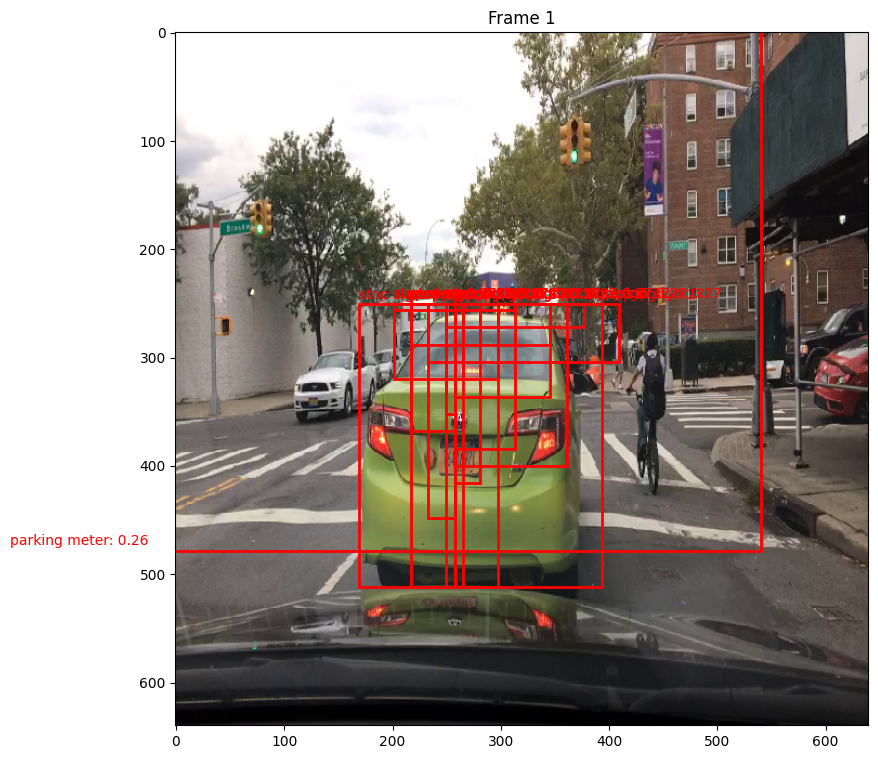

1/1 [==============================] - 0s 51ms/step
[0.02038159 0.22677164 0.20200358 0.         0.13120188 0.01926525
 0.06170347 0.15507297 0.15293215 0.03066748]
[0.01030999 0.25082386 0.17862733 0.         0.07573305 0.02919451
 0.06967753 0.12129485 0.24985419 0.01448469]
[0.0117104  0.24462663 0.18543735 0.         0.08272376 0.03134026
 0.07245498 0.12604311 0.22654863 0.01911487]
[0.02619808 0.22036868 0.18625835 0.         0.10052618 0.03515832
 0.07195994 0.12819435 0.19210957 0.03922653]
[0.00119243 0.22784927 0.21761036 0.         0.07279264 0.02122735
 0.0716944  0.11830157 0.26310727 0.00622471]
Margin = 0.1634790301322937
[0.01993    0.24530046 0.19559982 0.         0.10360247 0.01945959
 0.0691386  0.13135812 0.1827331  0.03287783]
[0.01007572 0.24580027 0.18599284 0.         0.08967116 0.03124472
 0.07281591 0.13410245 0.21301466 0.01728226]
[0.01132499 0.2221891  0.18506493 0.         0.09322426 0.0359999
 0.07054943 0.15805918 0.1934488  0.03013942]
[0.02527095 0.218

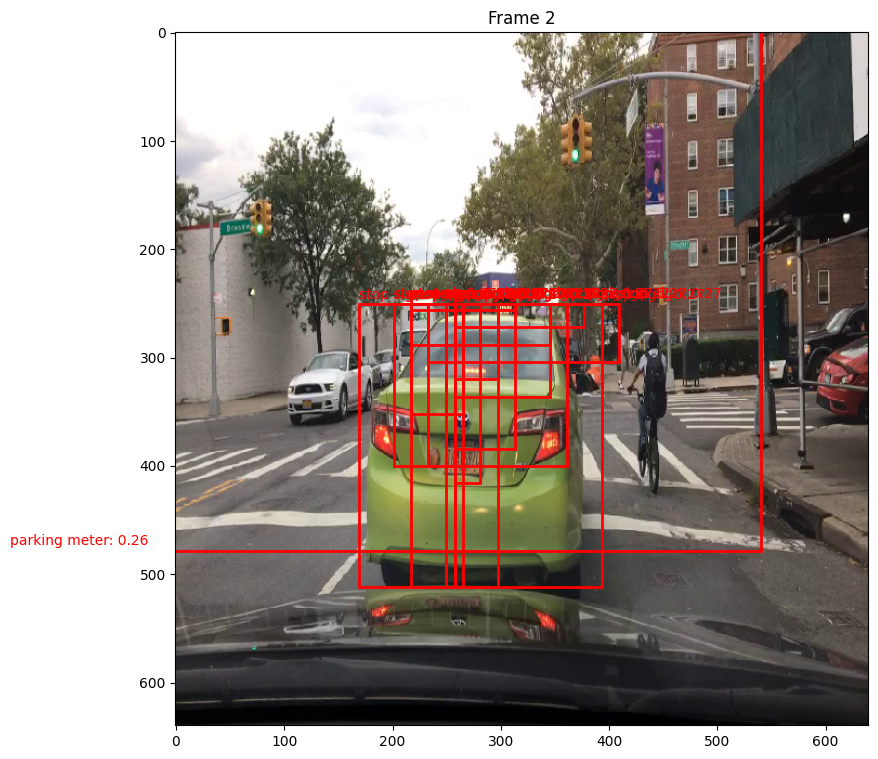

1/1 [==============================] - 0s 50ms/step
[0.02038033 0.22678049 0.20199643 0.         0.13120075 0.019264
 0.06169429 0.15508027 0.15293624 0.03066722]
[0.01030195 0.25081372 0.17864336 0.         0.07573377 0.02920215
 0.0696689  0.12129921 0.24987058 0.01446634]
[0.01170432 0.24461593 0.18545702 0.         0.08271912 0.03135103
 0.07244964 0.12603974 0.22656251 0.01910069]
[0.02619667 0.22037046 0.18625861 0.         0.10052632 0.03515692
 0.07196005 0.12819599 0.19211131 0.03922368]
[0.00119442 0.22784516 0.21760443 0.         0.07278933 0.02122897
 0.07169311 0.11830345 0.26311454 0.0062266 ]
Margin = 0.1634863168001175
[0.01993912 0.24526347 0.19557606 0.         0.1035973  0.01947957
 0.06917059 0.1313578  0.18272844 0.03288766]
[0.0100685  0.24579252 0.18600658 0.         0.08965893 0.03125397
 0.07281268 0.13410681 0.21302673 0.01727327]
[0.01132222 0.22219254 0.18506573 0.         0.09322391 0.0359963
 0.07054996 0.15805918 0.1934514  0.03013875]
[0.02527214 0.21893

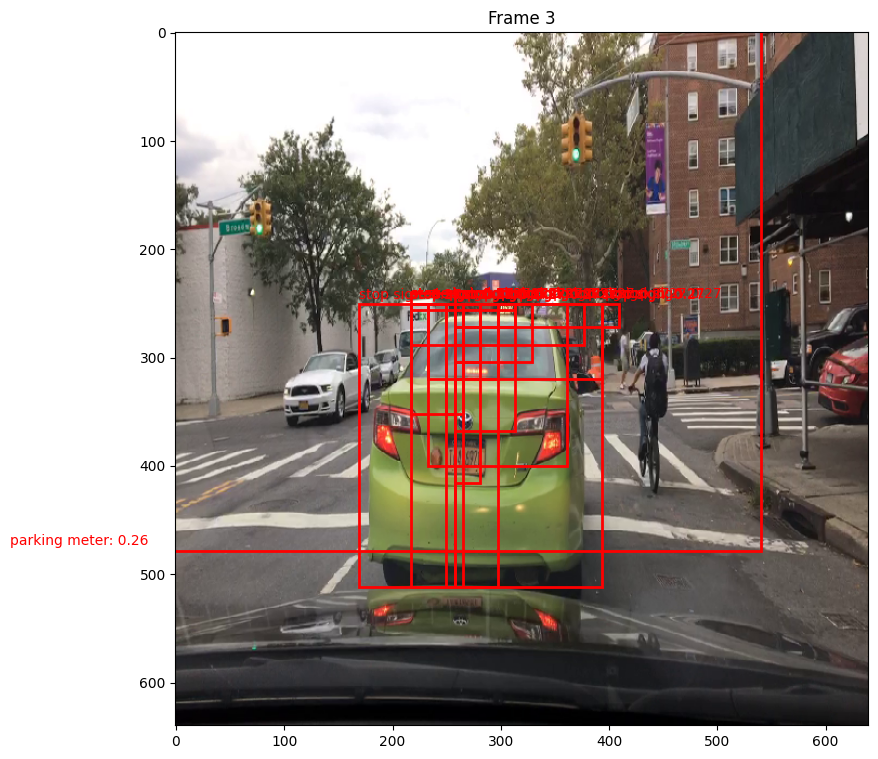

1/1 [==============================] - 0s 52ms/step
[0.02037901 0.22678007 0.20199823 0.         0.13120289 0.01926371
 0.06169467 0.15507908 0.15293603 0.03066631]
[0.0102802  0.25084472 0.17865108 0.         0.07571965 0.02919372
 0.06965151 0.12132198 0.24989451 0.01444263]
[0.01169477 0.24463925 0.18546948 0.         0.08270057 0.03134108
 0.07244417 0.12605338 0.22656912 0.01908819]
[0.02619804 0.22036691 0.18625808 0.         0.10052311 0.03515827
 0.07196129 0.12819707 0.19211075 0.03922648]
[0.0011944  0.22784953 0.21760495 0.         0.07279016 0.02122863
 0.07169196 0.11830355 0.26311034 0.0062265 ]
Margin = 0.16348211467266083
[0.01994061 0.24526034 0.19558088 0.         0.10360218 0.01947034
 0.0691552  0.13136083 0.1827322  0.03289742]
[0.01005617 0.24583462 0.1860173  0.         0.08964237 0.03123154
 0.07281    0.13412102 0.21302214 0.01726484]
[0.01132517 0.22218789 0.18506469 0.         0.09322415 0.03600046
 0.07055053 0.15805852 0.19344871 0.03013988]
[0.02527097 0.2

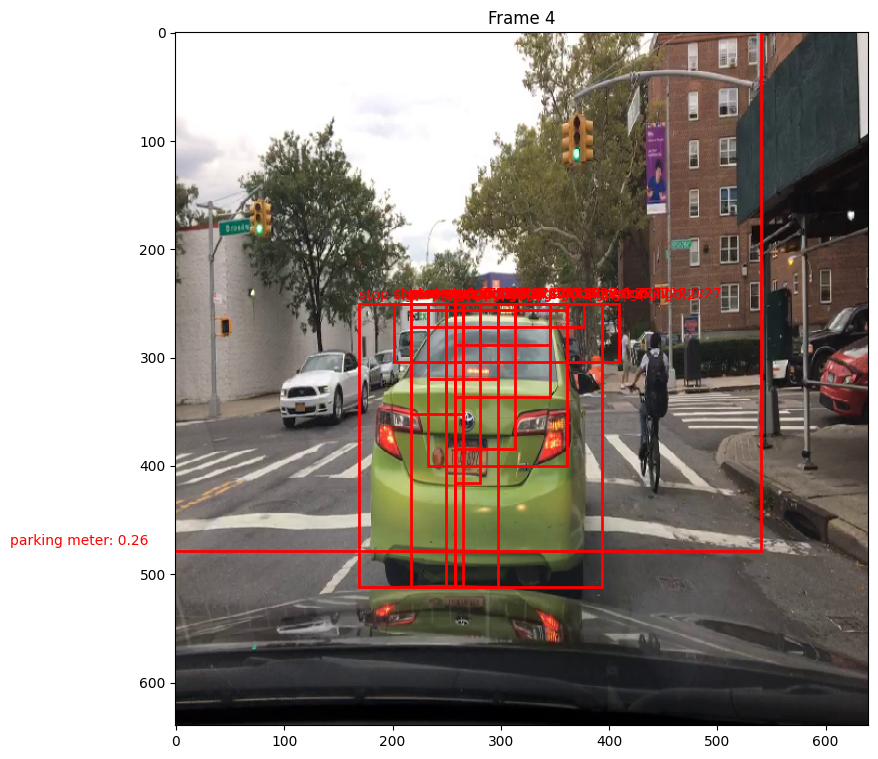

1/1 [==============================] - 0s 51ms/step
[0.02038247 0.22677484 0.20200162 0.         0.13120168 0.01926506
 0.06169963 0.1550747  0.15293391 0.0306661 ]
[0.01027444 0.25083464 0.17867774 0.         0.07571349 0.02920104
 0.06964989 0.12131995 0.24988608 0.01444273]
[0.01168642 0.24464129 0.18549775 0.         0.08269036 0.03134868
 0.07242857 0.12604585 0.22657937 0.01908173]
[0.02619827 0.22036593 0.18626115 0.         0.10052399 0.03516003
 0.07196192 0.12819383 0.19210951 0.03922536]
[0.00119041 0.22785473 0.21761    0.         0.07279118 0.02122492
 0.07168896 0.11830321 0.26311603 0.00622058]
Margin = 0.16348780691623688
[0.0199414  0.24525926 0.19556521 0.         0.10359187 0.01948372
 0.06916335 0.13136785 0.18274304 0.0328843 ]
[0.01005569 0.24582845 0.18602124 0.         0.08963813 0.03124097
 0.07281201 0.13411286 0.21302843 0.01726221]
[0.01132681 0.22218806 0.18506458 0.         0.09322488 0.03599919
 0.07055108 0.1580582  0.19344865 0.03013857]
[0.02527025 0.2

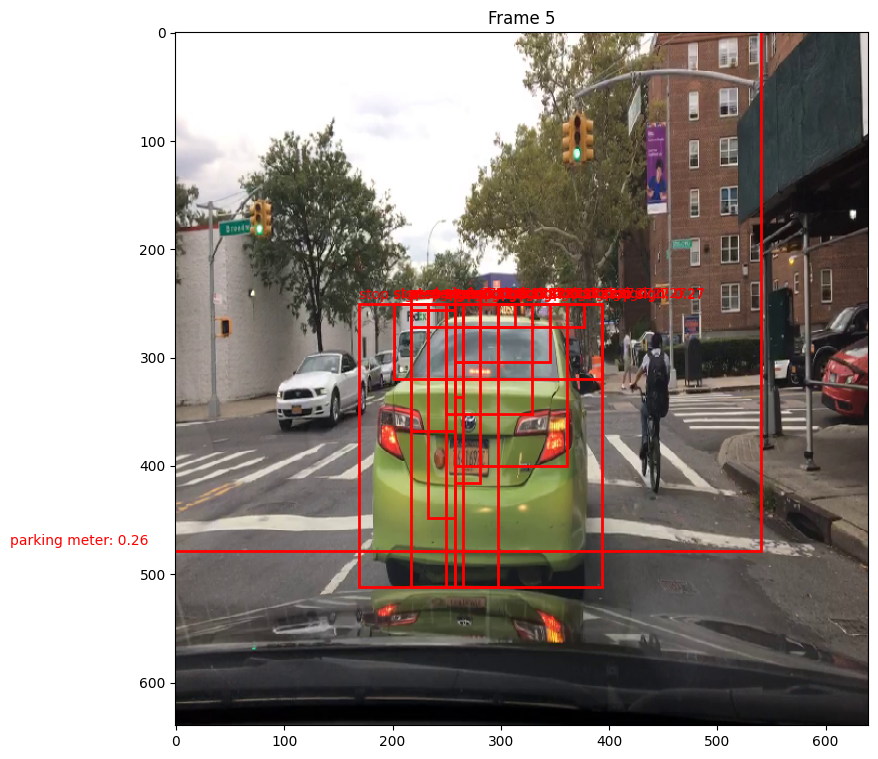

In [42]:
# Define a function to load and preprocess a single image
def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=(640, 640))
    img_array = img_to_array(img)
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) / 255.0
    return img_tensor

# Assuming detector, cls_list, and image_files are defined in your code
detection_results = {}

# Define number of frames to show
max_frames_to_display = 4

for frame_number, frame_path in enumerate(image_files):
    frame = load_and_preprocess_image(os.path.join(image_folder, frame_path))
    
    # Create a new figure for each frame
    plt.figure(figsize=(16, 9))

    # Display the loaded image using matplotlib
    plt.imshow(frame.numpy())
    plt.title(f"Frame {frame_number + 1}")

    # Perform object detection
    detections = detector(frame)
    boxes = np.asarray(detections["boxes"])
    cls_prob = np.asarray(detections["cls_prob"])

    # Visualize bounding boxes and class names
    for box, prob_list in zip(boxes, cls_prob):
        cur_min = np.min(prob_list)
        prob_list = prob_list - cur_min
        prob_list = prob_list / np.sum(prob_list)
        print(prob_list)
        '''for box, prob_list in zip(boxes, cls_prob):
        cur_min = np.min(prob_list)'''
        
        # Select max probability and associated data to display
        probability = max(prob_list)
        
        if probability > .26:
            print(f"Margin = {probability - cur_min}")

            chosen_class = np.argmax(prob_list)
            name = cls_list[chosen_class]

            # Extract coordinates
            ymin, xmin, ymax, xmax = box

            # Draw bounding box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(rect)

            # Add label
            label = f"{name}: {probability:.2f}"
            plt.text(xmin, ymax - 5, label, color='red')

    plt.show()
    if frame_number >= max_frames_to_display:
        break